# Tarea 3 Análisis de datos - Series Temporales

Referencia: https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/refs/heads/main/output/temperatura_dmc/2023/2023_temperatura_dmc.csv


Para la segunda tarea, utilizaremos el mismo conjunto de datos para realizar una regresión lineal simple. En este análisis, identificaremos y seleccionaremos las variables adecuadas para x e y, con el objetivo de explorar la relación entre ellas y obtener un modelo predictivo basado en los datos proporcionados.

In [195]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler

import joblib
import warnings

warnings.filterwarnings("ignore")
%matplotlib notebook
%matplotlib inline

In [196]:
url = 'https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/refs/heads/main/output/temperatura_dmc/2023/2023_temperatura_dmc.csv'
df = pd.read_csv(url)
df.head()

,time,latitud,longitud,Ts_Valor,CodigoNacional,nombreEstacion
0,2023-01-01 01:00:00,-18.35555,-70.34028,20.0,180005.0,"Chacalluta, Arica Ap."
1,2023-01-01 02:00:00,-18.35555,-70.34028,20.3,180005.0,"Chacalluta, Arica Ap."
2,2023-01-01 03:00:00,-18.35555,-70.34028,20.5,180005.0,"Chacalluta, Arica Ap."
3,2023-01-01 04:00:00,-18.35555,-70.34028,20.4,180005.0,"Chacalluta, Arica Ap."
4,2023-01-01 05:00:00,-18.35555,-70.34028,19.8,180005.0,"Chacalluta, Arica Ap."


In [198]:
def getVarDMC_y(url, est, y_i, y_e):
    var = url.split('/')[-2]
    for y in range(y_i, y_e+1, 1):
        url_ = f'{url}{str(y)}/{str(y)}_{var}.csv'
        if y==y_i:
            df = pd.read_csv(url_)
            df = df[df.nombreEstacion==est]
        else:
            df_ = pd.read_csv(url_)
            df_ = df_[df_.nombreEstacion==est]
            df = pd.concat([df, df_])
    df['time'] = pd.to_datetime(df['time'])
    df['CodigoNacional'] = df['CodigoNacional'].astype(str)
    return df

In [199]:
estacion = 'Quinta Normal, Santiago'
year_ini = 2018
year_end = 2023

df_temp = getVarDMC_y('https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/refs/heads/main/output/temperatura_dmc/', estacion, year_ini, year_end)


df_temp['Ts_Valor'] = df_temp['Ts_Valor'].fillna(df_temp['Ts_Valor'].rolling(window=5, min_periods=1).mean())

In [200]:
df_temp.describe()

,time,latitud,longitud,Ts_Valor
count,50290,5.029000e+04,5.029000e+04,50290.000000
mean,2020-11-14 14:43:43.583217152,-3.344500e+01,-7.068278e+01,15.367121
min,2018-01-01 01:00:00,-3.344500e+01,-7.068278e+01,-2.300000
25%,2019-06-09 04:15:00,-3.344500e+01,-7.068278e+01,9.700000
50%,2020-11-14 16:30:00,-3.344500e+01,-7.068278e+01,14.400000
75%,2022-04-22 17:45:00,-3.344500e+01,-7.068278e+01,20.600000
max,2023-09-29 07:00:00,-3.344500e+01,-7.068278e+01,38.000000
std,NaN,7.105498e-15,1.421100e-14,7.507554


In [201]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50290 entries, 118552 to 106865
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            50290 non-null  datetime64[ns]
 1   latitud         50290 non-null  float64       
 2   longitud        50290 non-null  float64       
 3   Ts_Valor        50290 non-null  float64       
 4   CodigoNacional  50290 non-null  object        
 5   nombreEstacion  50290 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 2.7+ MB


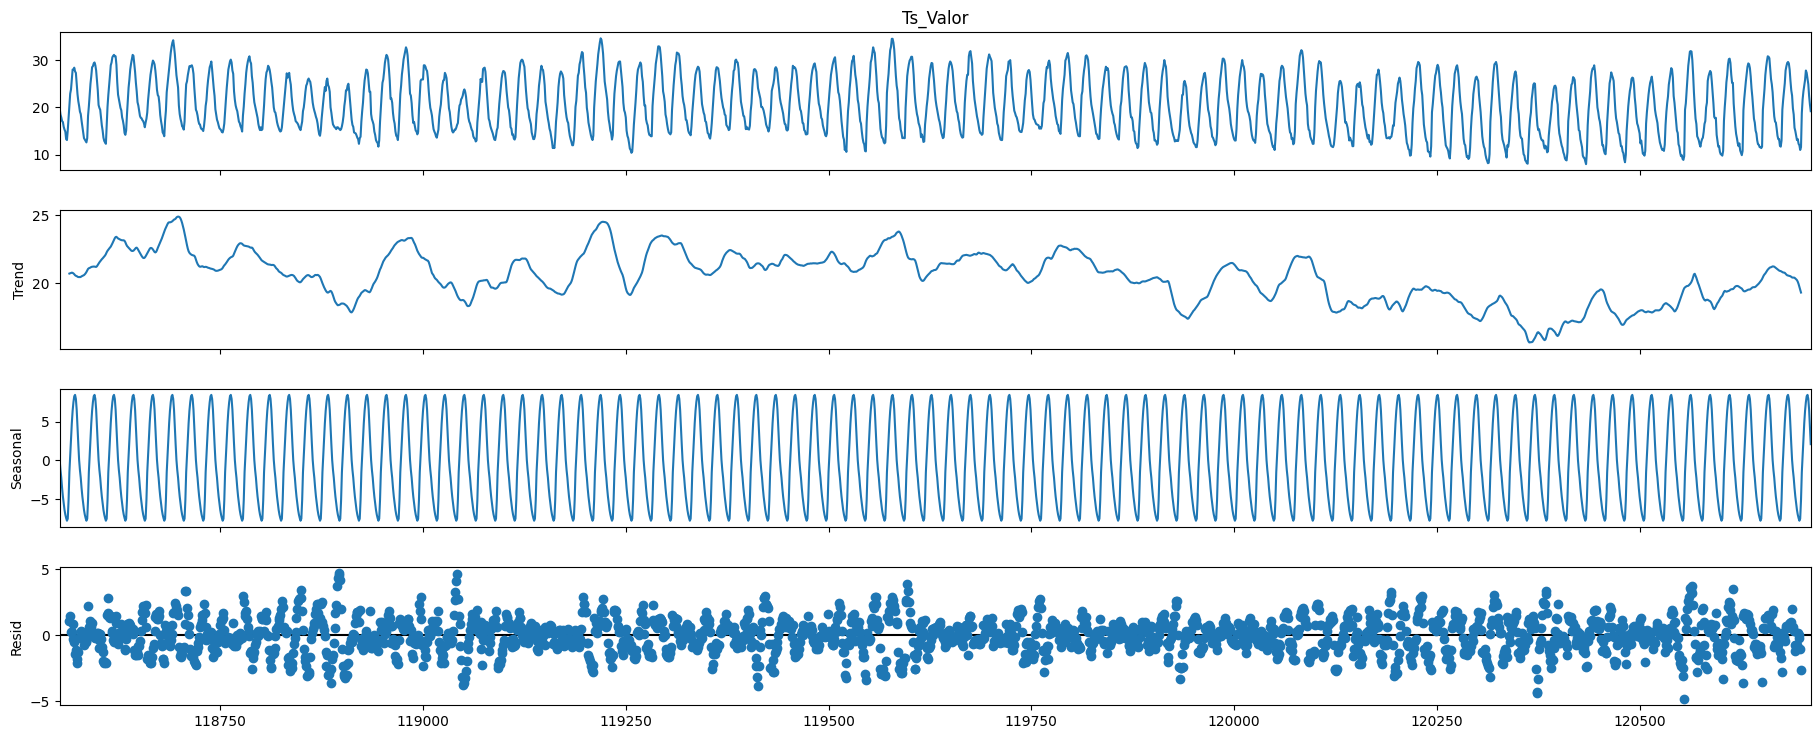

In [202]:
decomposition = seasonal_decompose(df_temp[:(24*30*3)]['Ts_Valor'], model='additive', period=24)

# Graficar la descomposición
fig = decomposition.plot()
fig.set_size_inches(20, 8)
plt.show()


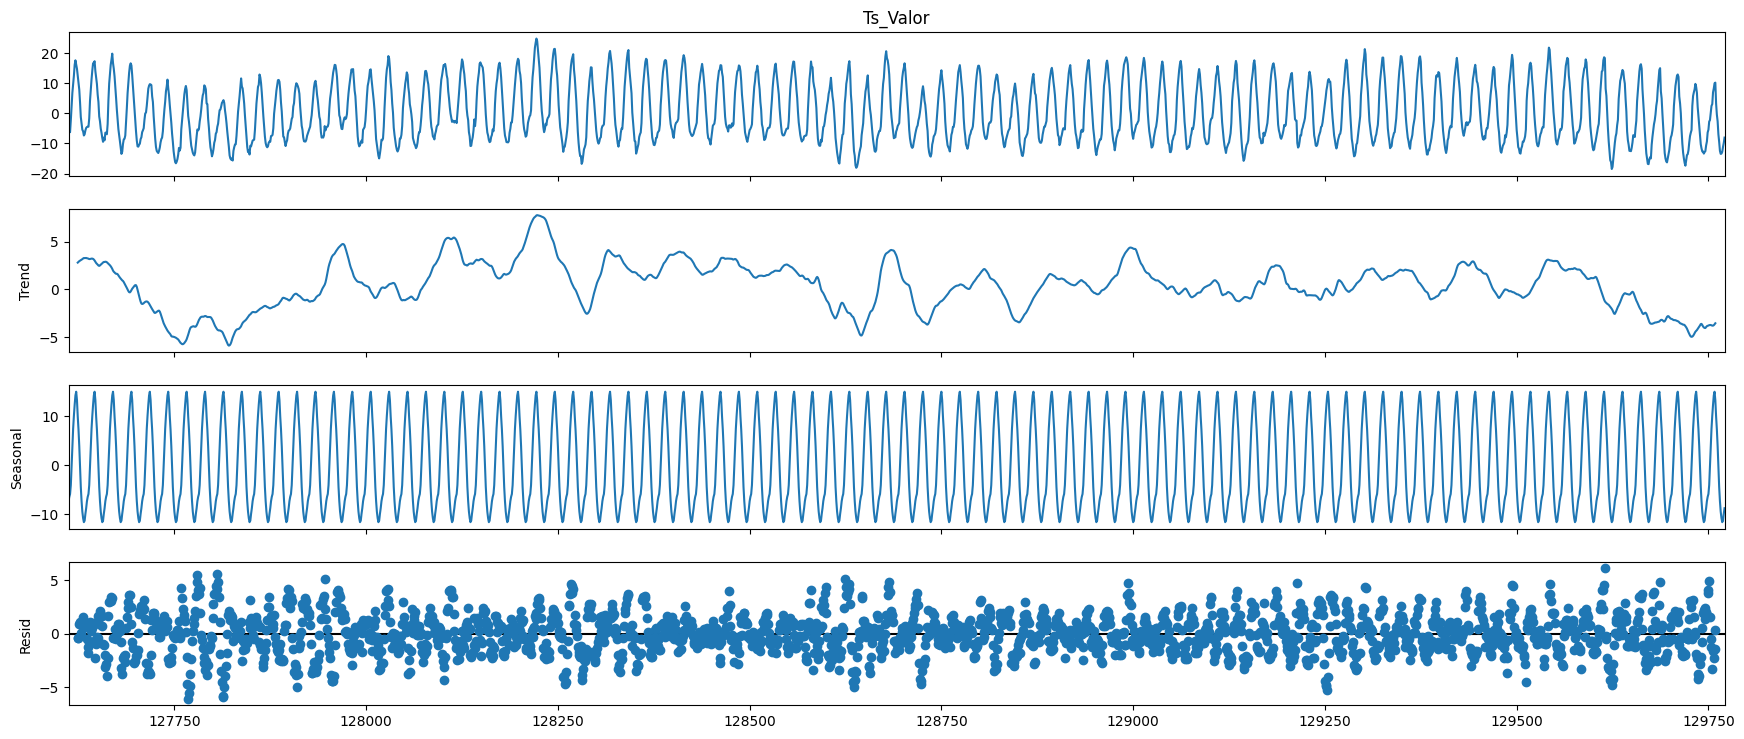

In [203]:
d = 24*365
decomposition = seasonal_decompose(df_temp['Ts_Valor'].diff(d)[d:][:(24*30*3)], model='additive', period=24)

# Graficar la descomposición
fig = decomposition.plot()
fig.set_size_inches(20, 8)
plt.show()


<Axes: xlabel='time'>

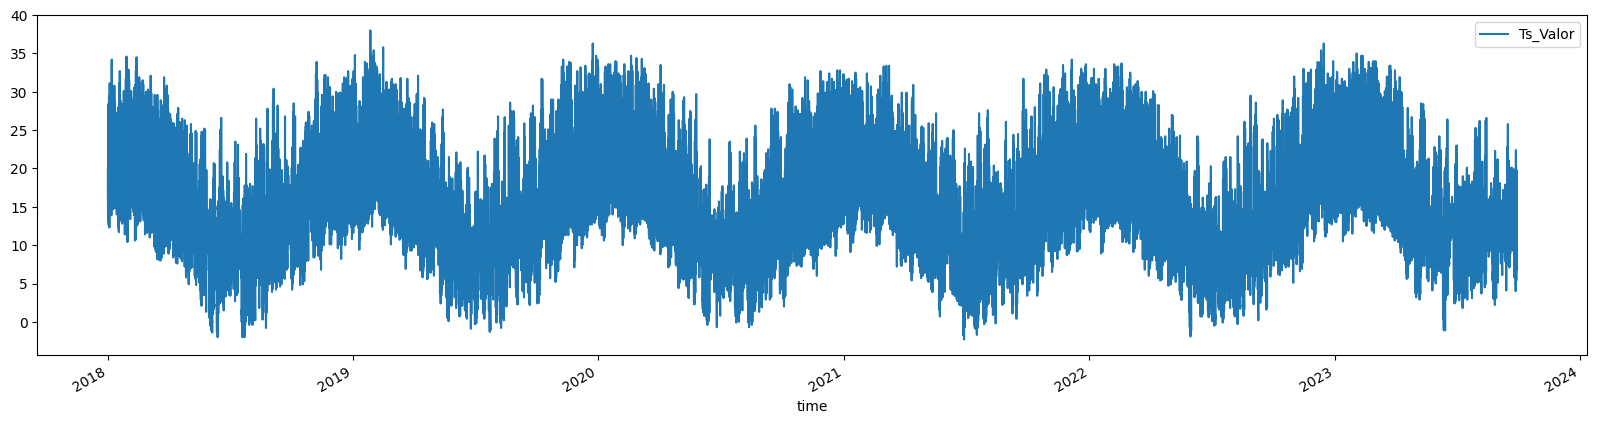

In [204]:
# 4 años
df_temp[['time', 'Ts_Valor']].plot(x='time', y='Ts_Valor', figsize=(20,5))

<Axes: xlabel='time'>

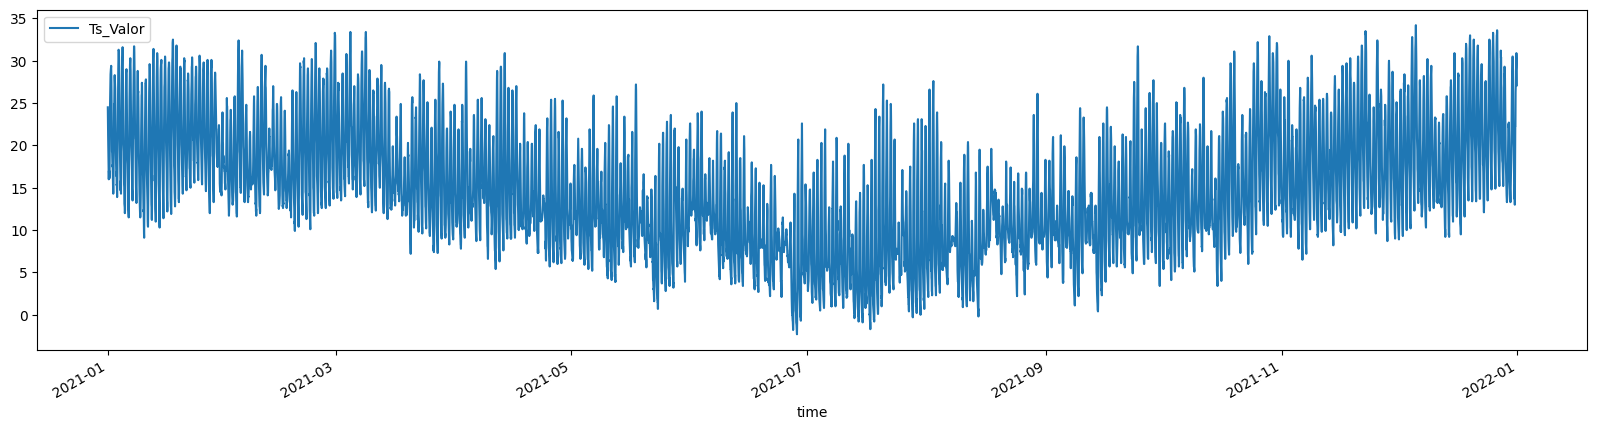

In [205]:
# 1 año
df_temp[(df_temp['time'] >= '2021-01-01') & (df_temp['time'] < '2022-01-01')].plot(x='time', y='Ts_Valor', figsize=(20,5))

<Axes: xlabel='time'>

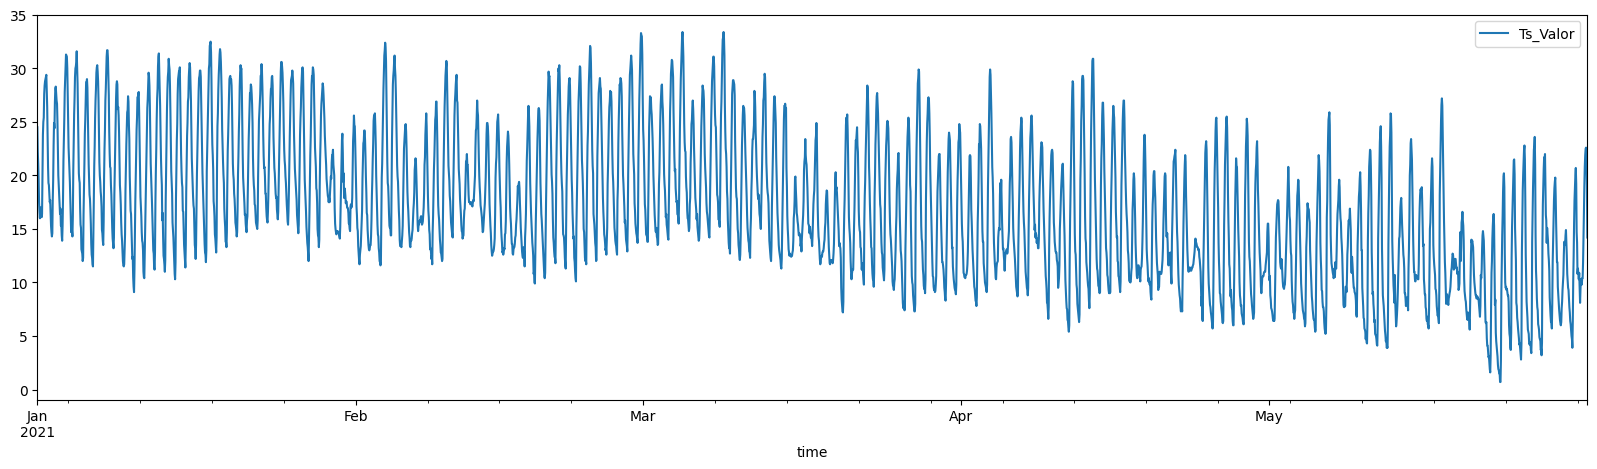

In [206]:
# 6 meses
df_temp[(df_temp['time'] >= '2021-01-01') & (df_temp['time'] < '2021-06-01')].plot(x='time', y='Ts_Valor', figsize=(20,5))

<Axes: xlabel='time'>

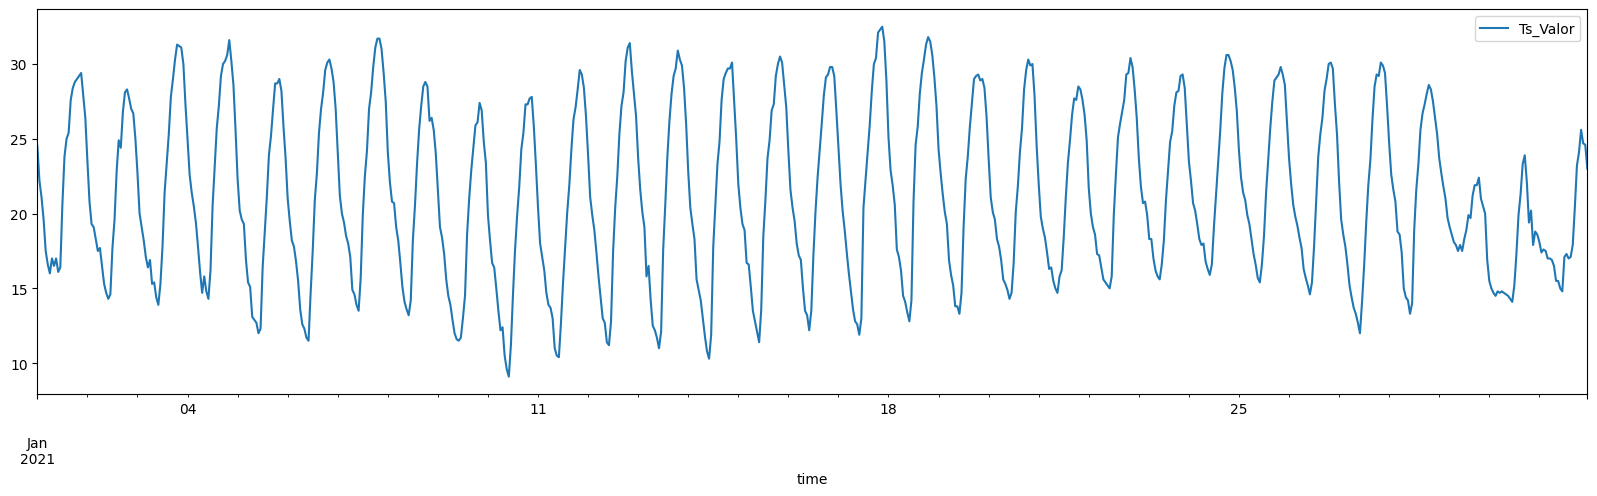

In [207]:
# 1 mes
df_temp[(df_temp['time'] >= '2021-01-01') & (df_temp['time'] < '2021-02-01')].plot(x='time', y='Ts_Valor', figsize=(20,5))

<Axes: xlabel='time'>

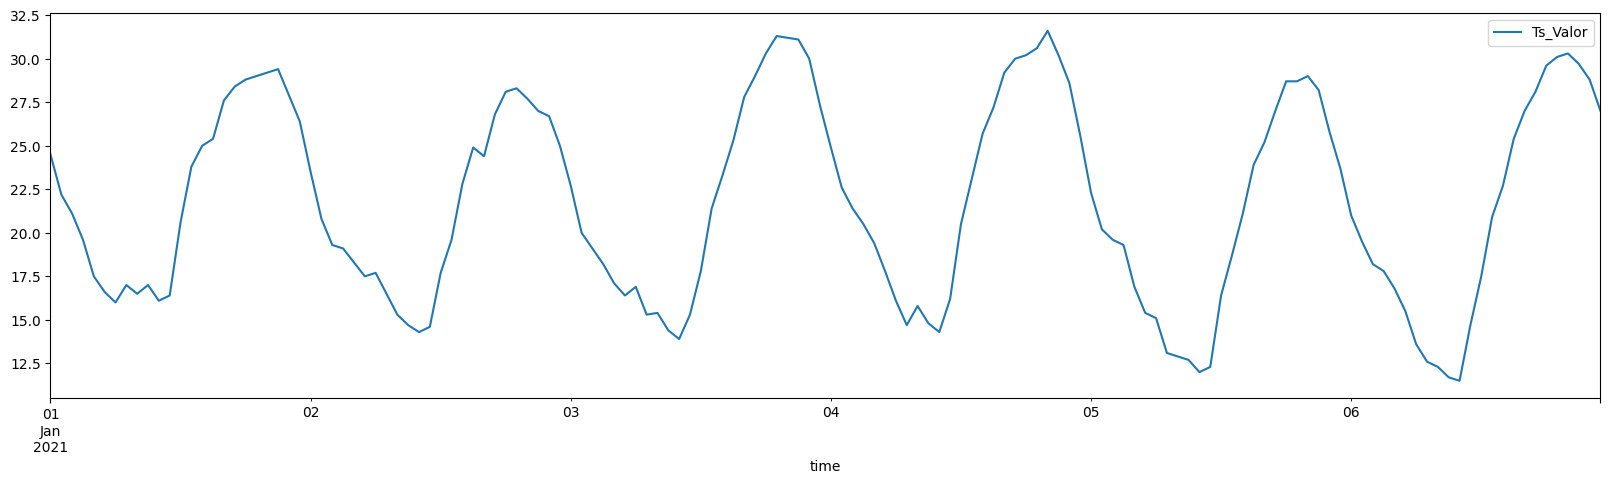

In [208]:
# 1 semana
df_temp[(df_temp['time'] >= '2021-01-01') & (df_temp['time'] < '2021-01-07')].plot(x='time', y='Ts_Valor', figsize=(20,5))

<Axes: xlabel='time'>

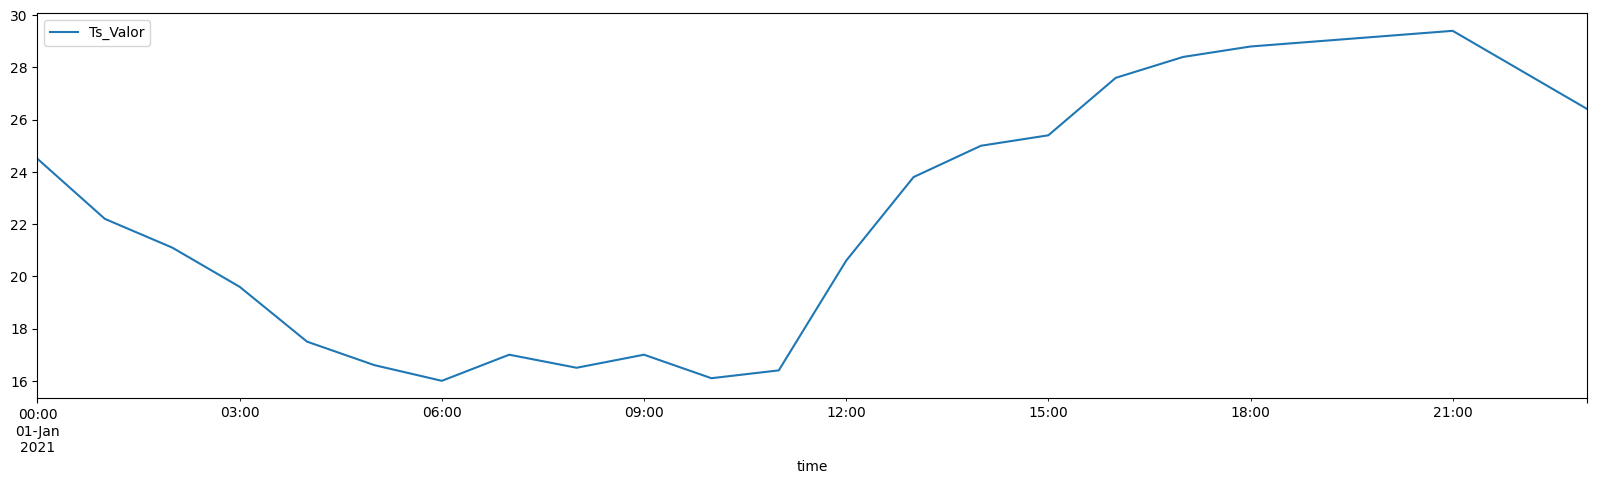

In [209]:
# 1 dia
df_temp[df_temp.time.dt.date == pd.to_datetime('2021-01-01').date()].plot(x='time', y='Ts_Valor', figsize=(20,5))

In [210]:
df_temp_ = df_temp[['time', 'Ts_Valor']]

df_temp_['Ts_Valor_24h'] = np.nan
df_temp_['Ts_Valor_6m'] = np.nan
df_temp_['Ts_Valor_1a'] = np.nan

df_temp_['Ts_Valor_24h'].iloc[:-24] = df_temp_['Ts_Valor'].iloc[24:]
df_temp_['Ts_Valor_6m'].iloc[:-4380] = df_temp_['Ts_Valor'].iloc[4380:]
df_temp_['Ts_Valor_1a'].iloc[:-8760] = df_temp_['Ts_Valor'].iloc[8760:]

df_temp_.dropna().corr()

,time,Ts_Valor,Ts_Valor_24h,Ts_Valor_6m,Ts_Valor_1a
time,1.000000,-0.092292,-0.091796,0.057654,-0.050625
Ts_Valor,-0.092292,1.000000,0.923929,-0.641978,0.501810
Ts_Valor_24h,-0.091796,0.923929,1.000000,-0.645291,0.499438
Ts_Valor_6m,0.057654,-0.641978,-0.645291,1.000000,-0.657311
Ts_Valor_1a,-0.050625,0.501810,0.499438,-0.657311,1.000000


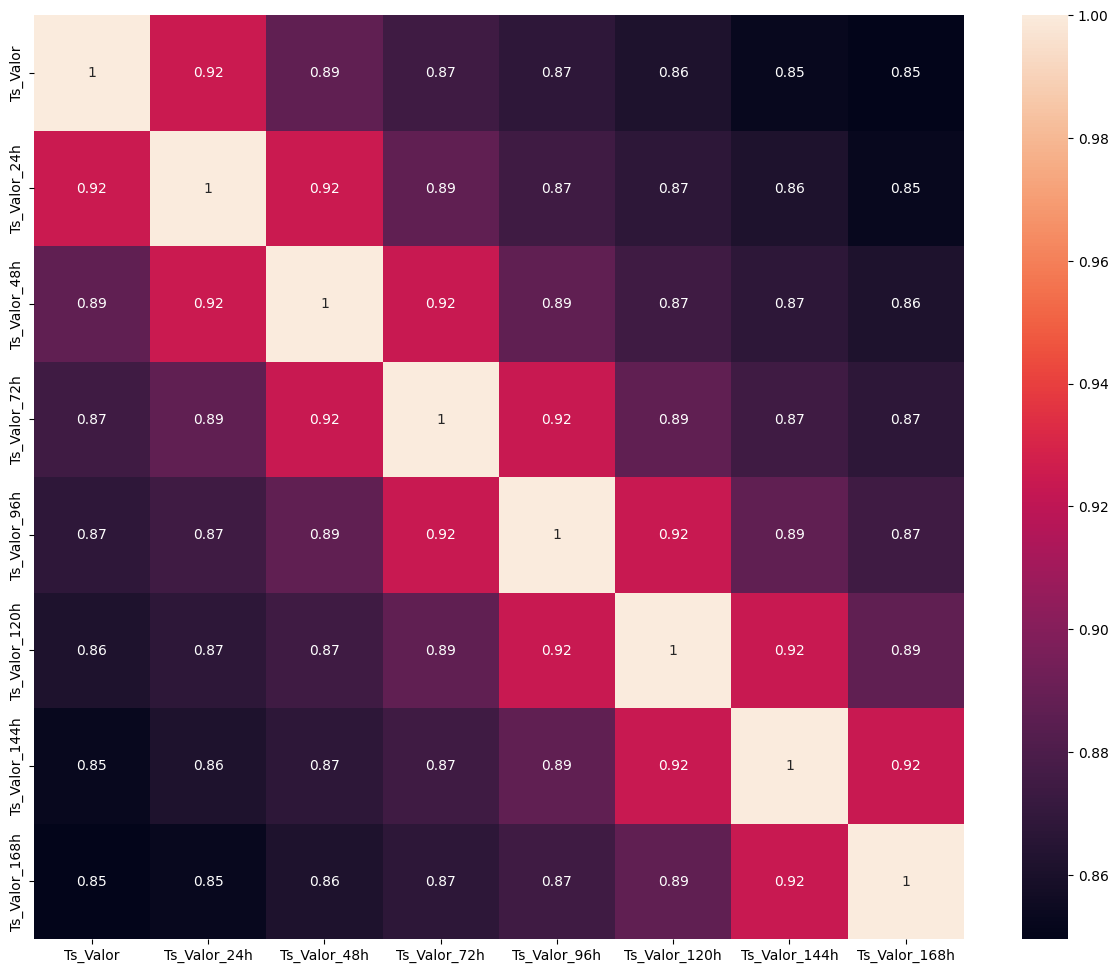

In [211]:
df_temp_ = df_temp[['time', 'Ts_Valor']]

n_h = 24
for k in range(7):
    df_temp_[f'Ts_Valor_{(k+1)*n_h}h'] = np.nan
    df_temp_[f'Ts_Valor_{(k+1)*n_h}h'].iloc[:-(k+1)*n_h] = df_temp_['Ts_Valor'].iloc[(k+1)*n_h:]

fig, ax = plt.subplots(1, figsize=(15,12))
sns.heatmap(df_temp_.drop(columns='time').dropna().corr(), annot=True);

<Axes: xlabel='Ts_Valor', ylabel='Ts_Valor_24h'>

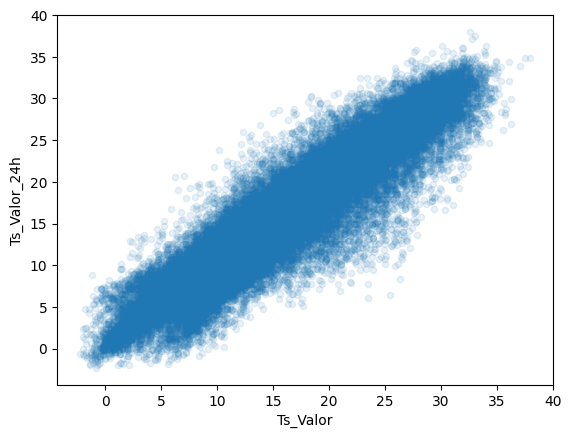

In [212]:
df_temp_.plot.scatter(x='Ts_Valor', y='Ts_Valor_24h', alpha=0.1)

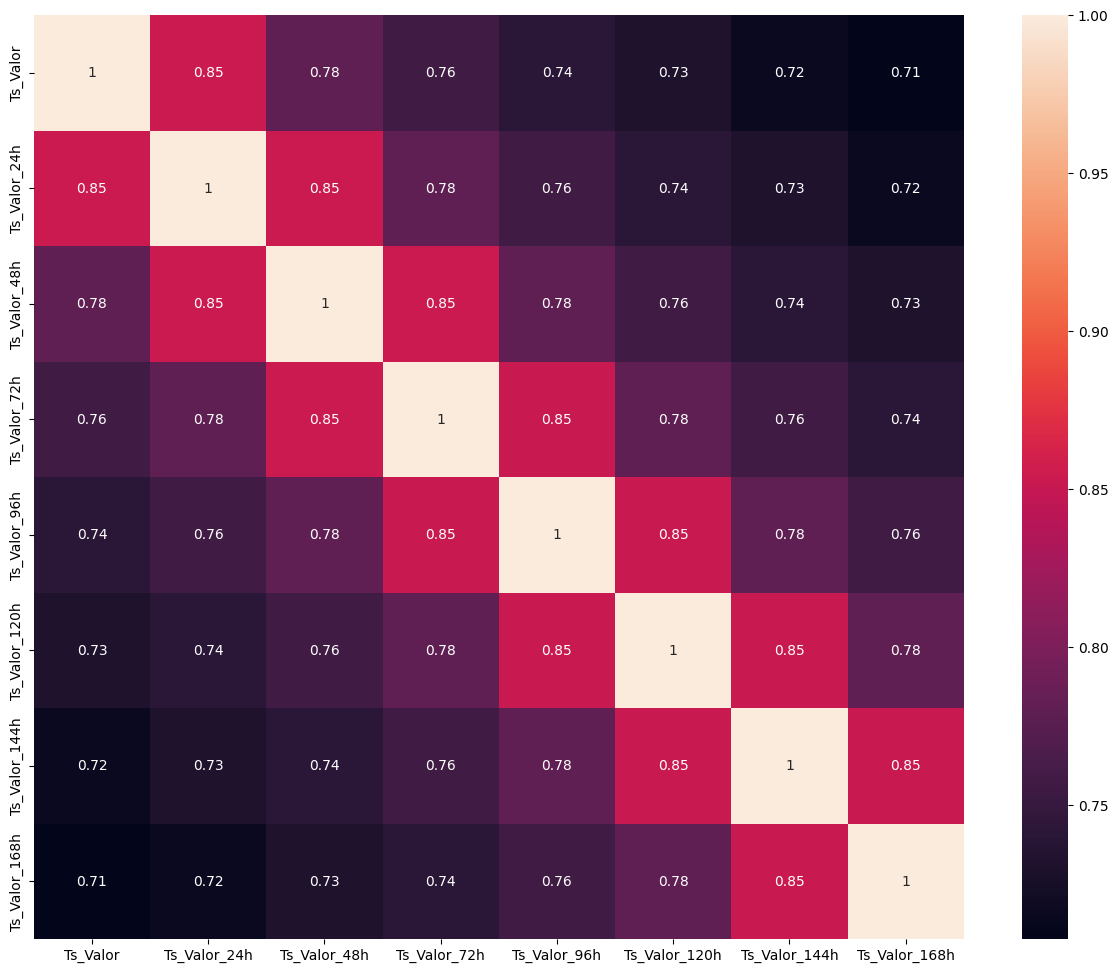

In [213]:
df_temp_ = df_temp[['time', 'Ts_Valor']]
df_temp_['Ts_Valor'] = df_temp_['Ts_Valor'].diff(24*365)
df_temp_ = df_temp_.dropna()
n_h = 24
for k in range(7):
    df_temp_[f'Ts_Valor_{(k+1)*n_h}h'] = np.nan
    df_temp_[f'Ts_Valor_{(k+1)*n_h}h'].iloc[:-(k+1)*n_h] = df_temp_['Ts_Valor'].iloc[(k+1)*n_h:]

fig, ax = plt.subplots(1, figsize=(15,12))
sns.heatmap(df_temp_.drop(columns='time').dropna().corr(), annot=True);

<Axes: xlabel='Ts_Valor', ylabel='Ts_Valor_24h'>

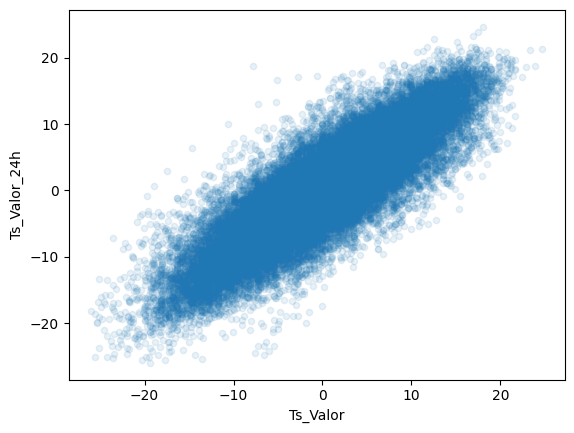

In [214]:
df_temp_.plot.scatter(x='Ts_Valor', y='Ts_Valor_24h', alpha=0.1)